# Лабораторная работа №2

## Подготовка: Генерация сигналов

6.283185307179586


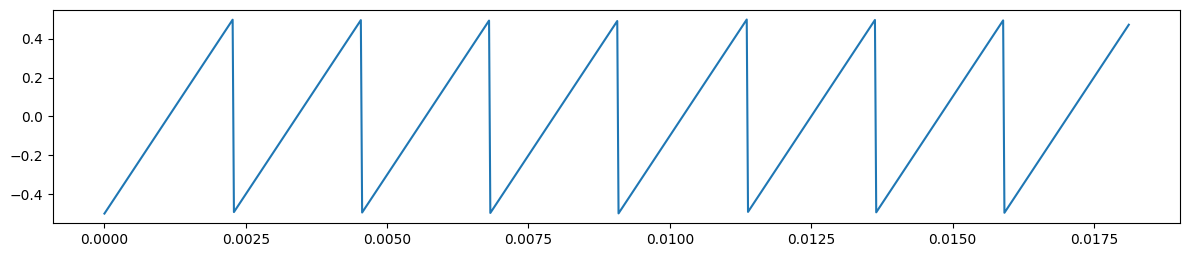

In [3]:
import math
import random
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import cmath

print(math.tau)

def _clamp(value: float, min_value: float, max_value: float) -> float:
    if value < min_value:
        return min_value
    if value > max_value:
        return max_value
    return value

def _validate_common_params(duration: float, rate: int, amplitude: float) -> tuple[int, float]:
    if duration <= 0:
        raise ValueError('duration_s должно быть > 0')
    if rate <= 0:
        raise ValueError('sample_rate_hz должно быть > 0')
    num_samples = int(round(duration * rate))
    safe_amplitude = _clamp(amplitude, 0.0, 1.0)
    return num_samples, safe_amplitude

def generate_sine(freq: float, duration: float, rate: int = 44100, amplitude: float = 1.0) -> List[float]:
    num_samples, amp = _validate_common_params(duration, rate, amplitude)
    if freq < 0:
        raise ValueError('frequency_hz должно быть >= 0')
    two_pi_f = 2.0 * math.pi * freq
    samples = [amp * math.sin(two_pi_f * (n / rate)) for n in range(num_samples)]
    return samples

def generate_triangle(
    freq: float,
    duration: float,
    rate: int = 44100,
    amplitude: float = 1.0,
) -> List[float]:
    num_samples, amp = _validate_common_params(duration, rate, amplitude)
    if freq < 0:
        raise ValueError("frequency_hz должно быть >= 0")
    samples: List[float] = []
    for n in range(num_samples):
        phase = (freq * (n / rate)) % 1.0
        tri = 2.0 * abs(2.0 * phase - 1.0) - 1.0
        samples.append(amp * tri)
    return samples

def generate_sawtooth(
    freq: float,
    duration: float,
    rate: int = 44100,
    amplitude: float = 1.0,
) -> List[float]:
    num_samples, amp = _validate_common_params(duration, rate, amplitude)
    samples: List[float] = []
    for n in range(num_samples):
        phase = (freq * (n / rate)) % 1.0
        saw = 2.0 * phase - 1.0
        samples.append(amp * saw)
    return samples

def generate_noise(
    duration: float,
    rate: int = 44100,
    amplitude: float = 1.0,
) -> List[float]:
    num_samples, amp = _validate_common_params(duration, rate, amplitude)
    samples: List[float] = []
    for _ in range(num_samples):
        samples.append(amp * random.gauss(0, 1))
    return samples

def generate_polyphonic(frequencies: List[float], duration: float, rate: int = 44100, amplitude: float = 1.0) -> List[float]:
    num_samples, amp = _validate_common_params(duration, rate, amplitude)
    samples = [0.0] * num_samples
    for freq in frequencies:
        two_pi_f = 2.0 * math.pi * freq
        for n in range(num_samples):
            samples[n] += amp * math.sin(two_pi_f * (n / rate))
    max_val = max(abs(s) for s in samples) if samples else 0
    if max_val > 1.0:
        samples = [s / max_val for s in samples]
    return samples

# Parameters
sample_rate = 44100
duration = 2.0
frequency = 440.0
amplitude = 0.5

# Generate signals
sinusoid_wave = generate_sawtooth(frequency, duration, sample_rate, amplitude)
noise = generate_noise(duration)
polyphonic_wave = generate_polyphonic([440, 660, 880], duration, sample_rate, amplitude)
t = np.linspace(0., duration, len(sinusoid_wave), endpoint=False)


plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(t[:800], sinusoid_wave[:800])
plt.tight_layout()
plt.show()

## 1. Дискретное преобразование Фурье (ДПФ) - Демонстрация

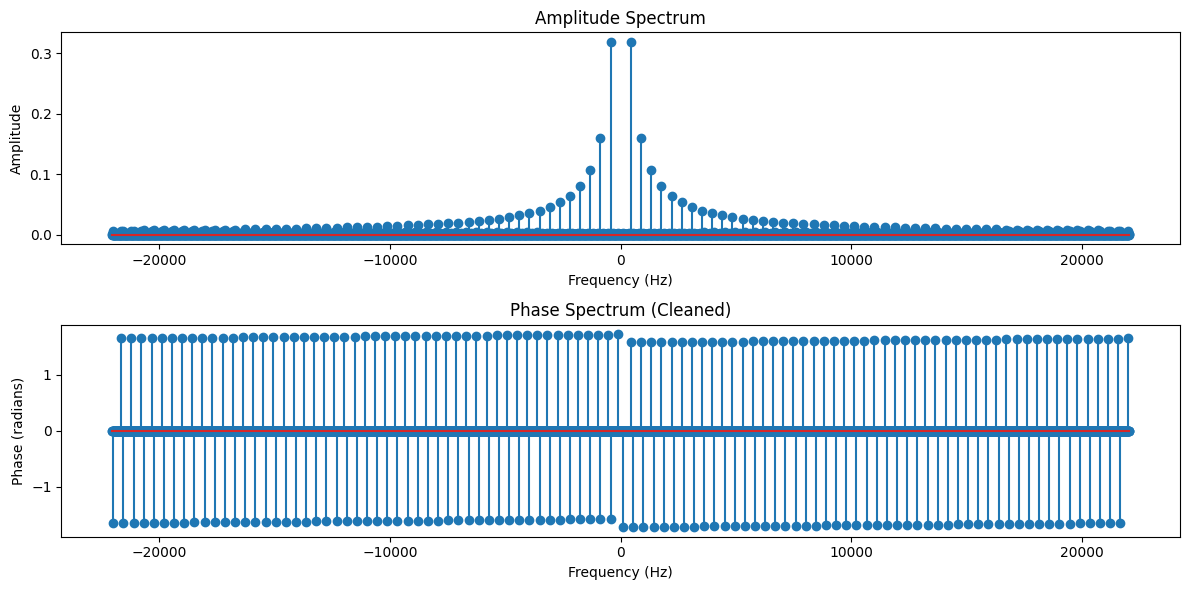

In [ ]:
def dft(signal: List[float]) -> List[complex]:
    # Прмяое преобразование Фурье
    N = len(signal)
    return [sum(signal[n] * cmath.exp(-2j * cmath.pi * k * n / N) for n in range(N)) for k in range(N)]

def idft(spectrum: List[complex]) -> List[float]:
     # Обратное преобразование Фурье
    N = len(spectrum)
    samples = [sum(spectrum[k] * cmath.exp(2j * cmath.pi * k * n / N) for k in range(N)) / N for n in range(N)]
    return [s.real for s in samples] 

def plot_spectrum(spectrum: List[complex], rate: int, max_freq: int = 2000):
    N = len(spectrum)
    amplitudes = [2 * abs(c) / N for c in spectrum]
    phases = [np.angle(c) for c in spectrum]
    freqs = np.fft.fftfreq(N, 1/rate)
    
    max_amp = max(amplitudes) if amplitudes else 0
    phases_cleaned = [phases[i] if amplitudes[i] > max_amp * 0.01 else 0 for i in range(N)]

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.stem(freqs, amplitudes)
    plt.title('Amplitude Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    # plt.xlim(0, max_freq)
    
    plt.subplot(2, 1, 2)
    plt.stem(freqs, phases_cleaned)
    plt.title('Phase Spectrum (Cleaned)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (radians)')
    # plt.xlim(0, max_freq)
    plt.tight_layout()
    plt.show()

short_signal = sinusoid_wave[:4410] # Берем первые 4410 отсчетов (0.1 секунды)
dft_spectrum = dft(short_signal) # Вычисляем ДПФ
plot_spectrum(dft_spectrum, sample_rate, max_freq=1000) # Строим спектр

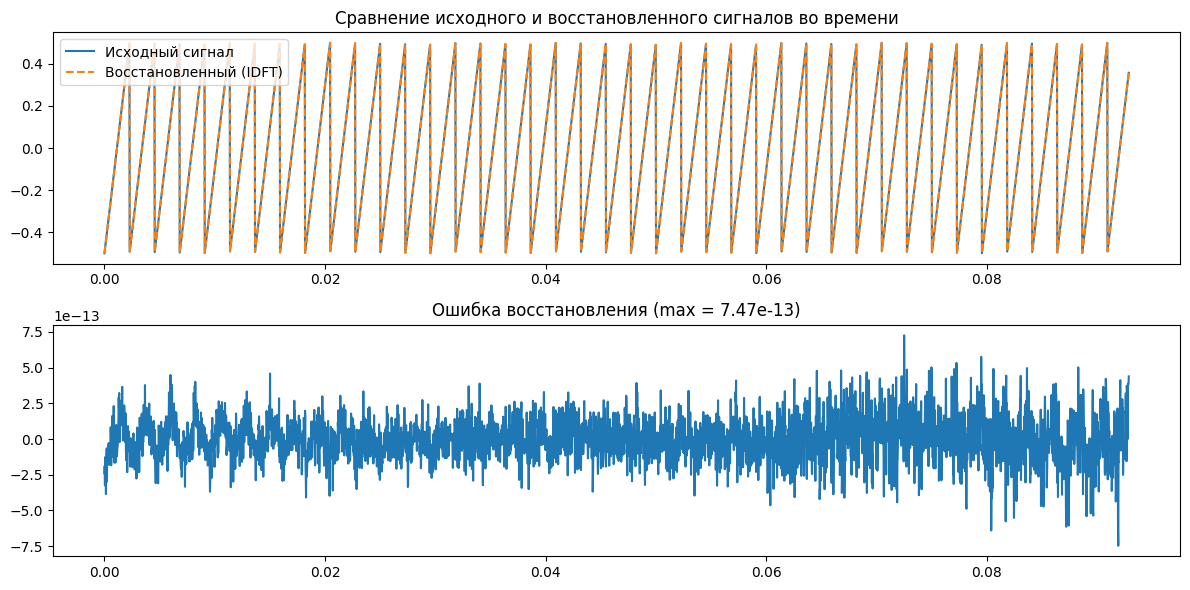

In [6]:
# 2. Восстановление сигнала по спектру с помощью DFT / IDFT

# Берём фрагмент уже исследуемого сигнала (пилообразный сигнал sinusoid_wave)
short_signal = sinusoid_wave[:4096]

# Прямое дискретное преобразование Фурье
spectrum = dft(short_signal)

# Обратное дискретное преобразование Фурье
reconstructed = idft(spectrum)

# Сравнение исходного и восстановленного сигналов во временной области
t_short = t[:len(short_signal)]
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_short, short_signal, label='Исходный сигнал')
plt.plot(t_short, reconstructed, '--', label='Восстановленный (IDFT)')
plt.legend()
plt.title('Сравнение исходного и восстановленного сигналов во времени')

# Ошибка восстановления
error = np.array(short_signal) - np.array(reconstructed)
plt.subplot(2, 1, 2)
plt.plot(t_short, error)
plt.title(f'Ошибка восстановления (max = {np.max(np.abs(error)):.2e})')
plt.tight_layout()
plt.show()


## 2. Быстрое преобразование Фурье (БПФ) - Ручная реализация

Тестируем на полном сигнале sinusoid_wave (длина 44100)
Сравниваем с numpy.fft...
Результаты совпадают: True


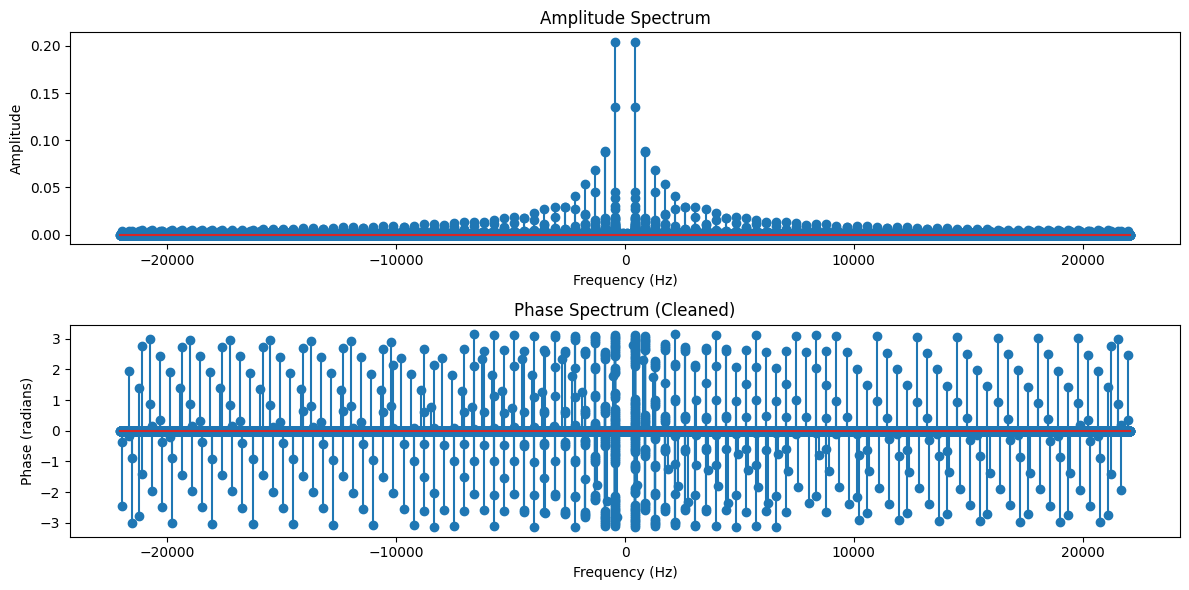

In [ ]:
def fft_manual(signal: List[complex]) -> List[complex]:
    N = len(signal)
    if N == 0:
        return []

    is_power_of_two = (N & (N - 1)) == 0 and N > 0
    if not is_power_of_two:
        N_padded = 1 << N.bit_length()
        signal = signal + [0j] * (N_padded - N)
        N = N_padded

    log2_N = N.bit_length() - 1
    reversed_indices = [int(f'{i:0{log2_N}b}'[::-1], 2) for i in range(N)]
    x = [signal[i] for i in reversed_indices]

    block_size = 2
    while block_size <= N:
        half_block = block_size // 2
        W_block = cmath.exp(-2j * cmath.pi / block_size)
        for block_start in range(0, N, block_size):
            W = 1.0
            for p in range(half_block):
                idx1 = block_start + p
                idx2 = idx1 + half_block
                t = W * x[idx2]
                x[idx2] = x[idx1] - t
                x[idx1] = x[idx1] + t
                W *= W_block
        block_size *= 2
    return x

def ifft_manual(spectrum: List[complex]) -> List[complex]:
    N = len(spectrum)
    conjugated_input = [c.conjugate() for c in spectrum]
    conjugated_fft = fft_manual(conjugated_input)
    return [c.conjugate() / N for c in conjugated_fft]

short_signal = sinusoid_wave[:4410] # Берем первые 4410 отсчетов (0.1 секунды)
dft_spectrum = fft_manual(short_signal) # Вычисляем ДПФ
plot_spectrum(dft_spectrum, sample_rate, max_freq=1000) # Строим спектр

In [ ]:
# 3. Восстановление сигнала по спектру с помощью FFT / IFFT

# Берём тот же фрагмент пилообразного сигнала, что и для DFT
short_signal_fft = sinusoid_wave[:4096]

# Прямое быстрое преобразование Фурье (FFT)
spectrum_fft = fft_manual([complex(v) for v in short_signal_fft])

# Обратное быстрое преобразование Фурье (IFFT)
reconstructed_fft_complex = ifft_manual(spectrum_fft)
reconstructed_fft = [x.real for x in reconstructed_fft_complex]

# Сравнение исходного и восстановленного сигналов во временной области
t_short_fft = t[:len(short_signal_fft)]
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_short_fft, short_signal_fft, label='Исходный сигнал')
plt.plot(t_short_fft, reconstructed_fft, '--', label='Восстановленный (IFFT)')
plt.legend()
plt.title('Сравнение исходного и восстановленного сигналов во времени (FFT/IFFT)')

# Ошибка восстановления
error_fft = np.array(short_signal_fft) - np.array(reconstructed_fft)
plt.subplot(2, 1, 2)
plt.plot(t_short_fft, error_fft)
plt.title(f'Ошибка восстановления (FFT/IFFT) (max = {np.max(np.abs(error_fft)):.2e})')
plt.tight_layout()
plt.show()


## 3. Цифровая фильтрация

--- Фильтрация полифонического сигнала с помощью fft_manual ---


НЧ-фильтр (ниже 500 Гц)


ВЧ-фильтр (выше 800 Гц)


Полосовой фильтр (600-700 Гц)


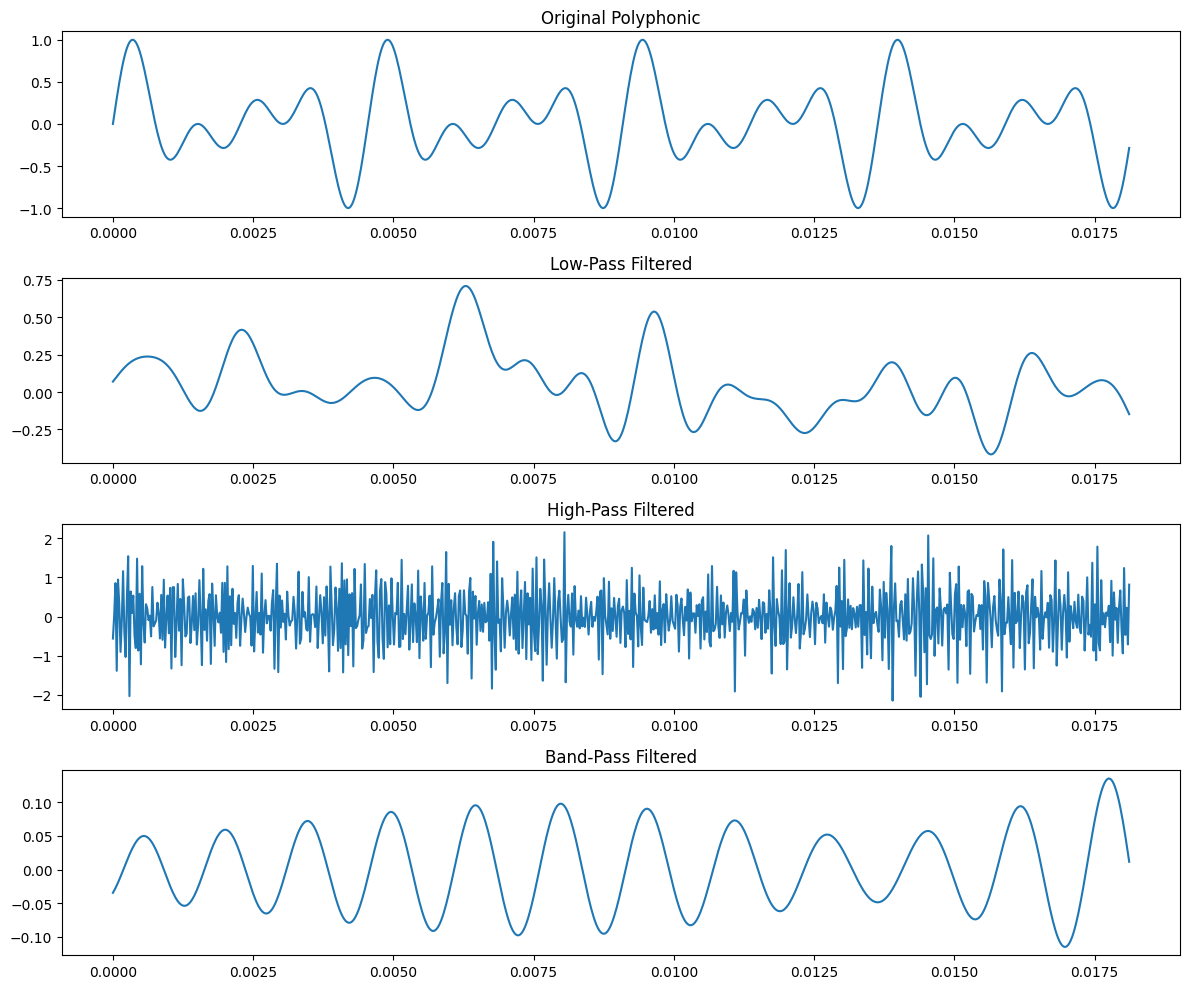

In [81]:
def apply_filter(signal: List[float], rate: int, cutoff_low: int = 0, cutoff_high: int = 0) -> List[float]:
    original_N = len(signal)
    signal_complex = [complex(v) for v in signal]

    spectrum = fft_manual(signal_complex)
    N_padded = len(spectrum)

    freqs = np.fft.fftfreq(N_padded, 1/rate)
    for i in range(N_padded):
        if (cutoff_high > 0 and abs(freqs[i]) > cutoff_high) or (cutoff_low > 0 and abs(freqs[i]) < cutoff_low):
            spectrum[i] = 0j

    filtered_padded_signal = ifft_manual(spectrum)

    return [v.real for v in filtered_padded_signal[:original_N]]

print('--- Фильтрация полифонического сигнала с помощью fft_manual ---')
display(Audio(noise, rate=sample_rate))

low_pass_filtered = apply_filter(noise, sample_rate, cutoff_high=1000)
print('НЧ-фильтр (ниже 500 Гц)')
display(Audio(low_pass_filtered, rate=sample_rate))

high_pass_filtered = apply_filter(noise, sample_rate, cutoff_low=10000)
print('ВЧ-фильтр (выше 800 Гц)')
display(Audio(high_pass_filtered, rate=sample_rate))

band_pass_filtered = apply_filter(noise, sample_rate, cutoff_low=600, cutoff_high=700)
print('Полосовой фильтр (600-700 Гц)')
display(Audio(band_pass_filtered, rate=sample_rate))

# --- Графики ---
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(t[:800], polyphonic_wave[:800])
plt.title('Original Polyphonic')
plt.subplot(4, 1, 2)
plt.plot(t[:800], low_pass_filtered[:800])
plt.title('Low-Pass Filtered')
plt.subplot(4, 1, 3)
plt.plot(t[:800], high_pass_filtered[:800])
plt.title('High-Pass Filtered')
plt.subplot(4, 1, 4)
plt.plot(t[:800], band_pass_filtered[:800])
plt.title('Band-Pass Filtered')
plt.tight_layout()
plt.show()